# Préambule - Environnement de travail

Ce notebook a été réalisé à partir de la dernière image Docker de Anaconda pour Python 3.  
Il a été lancé via la commande suivante:

```console
sudo docker run -i -t -p 8888:8888 continuumio/anaconda3 /bin/bash -c "/opt/conda/bin/conda install jupyter -y --quiet && mkdir /opt/notebooks && /opt/conda/bin/jupyter notebook --notebook-dir=/opt/notebooks --ip='*' --port=8888 --no-browser" 
```

L'image Docker en question est dispo [à cette adresse](https://hub.docker.com/r/continuumio/anaconda3/). 

# I - Description des données et visualisation

### Import des modules et fonctions utiles

In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")   # to avoid matpltlib warning messages

def plotROC(real, predicted):
    fpr, tpr, thresholds = roc_curve(real, predicted, pos_label=1)
    plt.clf()
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### Chargement des données
Les données absentes sont représentées par un point d'interrogation

In [2]:
data = pd.read_csv('adult.csv', na_values='?')

### Preprocessing

On commence par supprimer les lignes avec des valeurs manquantes (environ 7% des données)

In [3]:
data = data.dropna(how='any')

On regroupe les variables 'capital.gain' et 'capital.loss' qui sont toutes les deux positives en une seule variable 'capital.change' qui peut être négative en cas de perte en capital (positive sinon)

In [4]:
data['capital.change'] = data['capital.gain'] - data['capital.loss']
data = data.drop(['capital.gain', 'capital.loss'], axis=1)

On ignore la variable 'fnlwgt' qui représente la taille de la classe de population

In [5]:
data = data.drop('fnlwgt', axis=1)

### Exploration des données

Taille des données

In [6]:
data.shape

(30162, 13)

Echantillon

In [7]:
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income,capital.change
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,18,United-States,<=50K,-4356
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,40,United-States,<=50K,-3900
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,40,United-States,<=50K,-3900
5,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,45,United-States,<=50K,-3770
6,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,40,United-States,<=50K,-3770


Les différentes variables et leurs types.  

In [8]:
data.dtypes

age                int64
workclass         object
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
hours.per.week     int64
native.country    object
income            object
capital.change     int64
dtype: object

Quelques statistiques descriptives sur les variables numériques.  
On voit que certaines valeurs semblent aberrantes (heures travaillées à 99)

In [9]:
data.describe()

,age,education.num,hours.per.week,capital.change
count,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,10.121312,40.931238,1003.635369
std,13.134665,2.549995,11.979984,7430.372730
min,17.000000,1.000000,1.000000,-4356.000000
25%,28.000000,9.000000,40.000000,0.000000
50%,37.000000,10.000000,40.000000,0.000000
75%,47.000000,13.000000,45.000000,0.000000
max,90.000000,16.000000,99.000000,99999.000000


La variable a prédire est déséquilibrée: 75% des données concernent des personnes avec un revenu <= 50K $ par an.

In [10]:
data['income'].value_counts()

<=50K    22654
>50K      7508
Name: income, dtype: int64

### Visualisation

On représente ici le nombre de cas dans chaque catégorie sur quelques variables telles que l'age ou le sexe.

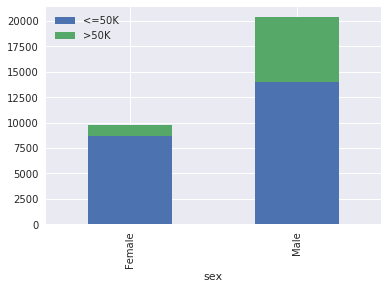

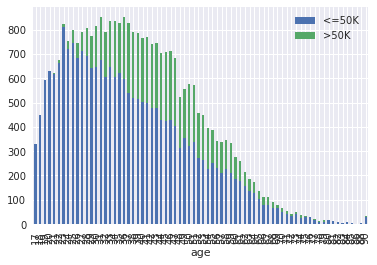

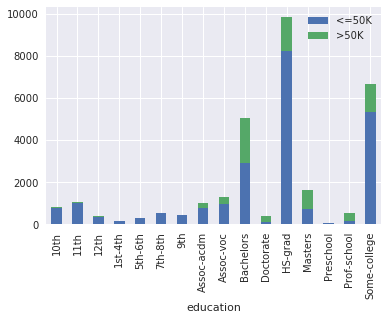

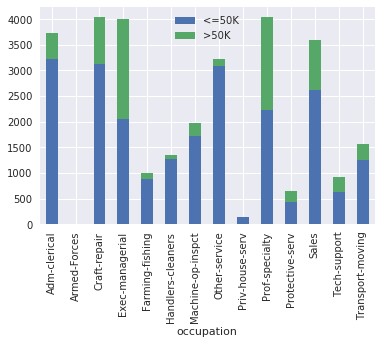

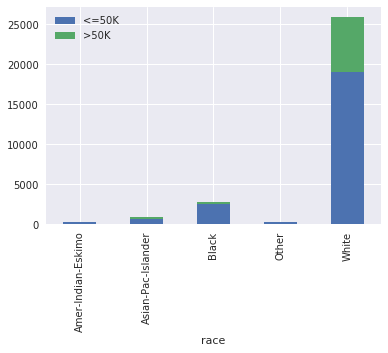

In [11]:
for column in ['sex', 'age', 'education', 'occupation', 'race']:
    df = pd.concat((data[column], pd.get_dummies(data['income'])), axis=1)
    df.groupby(column).sum().plot.bar(stacked=True)

On voit déjà que certaines variables comme le sexe, l'age le niveau d'études ou encore le métiers semblent
particulièrement explicatives si l'on cherche à prédire le fait de gagner ou non plus de 50K $ par an.

La population des personnes gagnant plus de 50K $ par an semble majoritairement composée d'hommes blancs d'age moyen
ayant  fait des études supérieures.

# II - Création d'un modèle prédictif

### Création des datasets d'entrainement, de validation et test

Variable à prédire

In [12]:
y = pd.get_dummies(data.income)['>50K']

Features utilisées pour la prédiction.  
On transforme ici les variables catégorielles en variables binaires, puis on les centre/réduit.

In [13]:
categorical_variables = ['workclass', 'education', 'marital.status', 'occupation',
                         'relationship', 'race', 'sex', 'native.country']
X = pd.DataFrame()
for variable in [col for col in data.columns if col != 'income']:
    if variable in categorical_variables:
        dummies = pd.get_dummies(data[variable], drop_first=False)
        column_names = [variable + '_' + category for category in dummies.columns]
        X[column_names] = dummies
    else:
        X[variable] = data[variable]

variables = X.columns
X = scale(X)

On sépare les données entre: 
- données d'entrainement, utilisées pour entraîner les modèles: 80% des données
- données de validation, utilisées pour sélectionner les hyperparamètres des modèles: 10% des données
- données de test, utilisées pour évaluer les modèles : 10% des données

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

On va ensuite entraîner différents modèles sur nos données.  
Etant donné que les classes a prédire sont déséquilibrées, la métrique utilisée sera l'[AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) (aire sous la [courbe ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).

### Entraînement des modèles

##### Régression logistique
On commence par entraîner une régression logistique sur les données.  
On teste différents paramètres de régularisation et on choisit le bon grâce au dataset de validation.

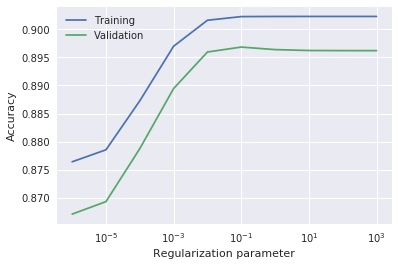

In [15]:
C_list =  [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.10, 1, 1e1, 1e2, 1e3]
train_result = []
valid_result = []
regressions = []

for C in C_list:
    lr = LogisticRegression(C=C, class_weight ='balanced')
    lr.fit(X_train, y_train)
    regressions.append(lr)
    train_result.append(roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
    valid_result.append(roc_auc_score(y_valid, lr.predict_proba(X_valid)[:,1]))

plt.plot(C_list, train_result)
plt.plot(C_list, valid_result)
plt.xscale('log')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

On voit que le modèle n'overfitte pas plus lorsque l'on a peu de régularisation (C élevé).  
On prend alors C=1e-2 comme paramètre de régularisation et on trace la courbe ROC sur les données de test

AUC on test data: 0.890


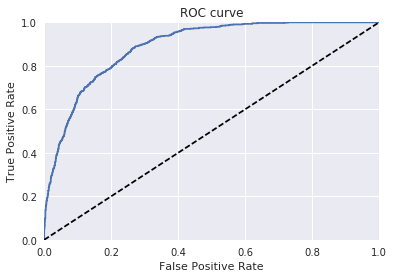

In [16]:
C = 1e-2
i = C_list.index(C)
lr = regressions[i]
auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC on test data: {:.3f}'.format(auc))
plotROC(y_test, lr.predict_proba(X_test)[:, 1])

Les 10 variables les plus importantes sont les suivantes:

In [17]:
coefs = pd.Series(lr.coef_.ravel()).apply(lambda x: abs(x))
coefs.sort(ascending=False)
important_features = coefs[:10].index
variables[important_features]

Index(['capital.change', 'marital.status_Married-civ-spouse', 'hours.per.week',
       'age', 'marital.status_Never-married', 'education.num',
       'relationship_Wife', 'relationship_Own-child',
       'occupation_Other-service', 'occupation_Exec-managerial'],
      dtype='object')

On va maintenant passer à des modèles non linéaires.

##### Arbre de décision
De manière similaire, on entraîne les données sur des arbres de décision, en testant différentes profondeurs d'arbre.

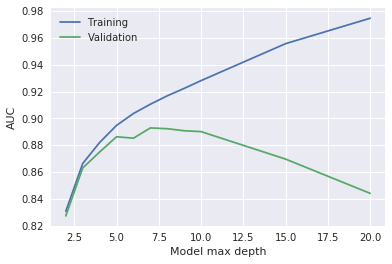

In [18]:
depths =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
train_result = []
valid_result = []
decision_trees = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced')
    dt.fit(X_train, y_train)
    decision_trees.append(dt)
    train_result.append(roc_auc_score(y_train, dt.predict_proba(X_train)[:,1]))
    valid_result.append(roc_auc_score(y_valid, dt.predict_proba(X_valid)[:,1]))

plt.plot(depths, train_result)
plt.plot(depths, valid_result)
plt.xlabel('Model max depth')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

On voit qu'on-delà d'une profondeur de 9, le modèle overfitte.  
Pour cette profondeur, l'AUC atteint est légèrement inférieur à 0,90.

AUC on test data: 0.890


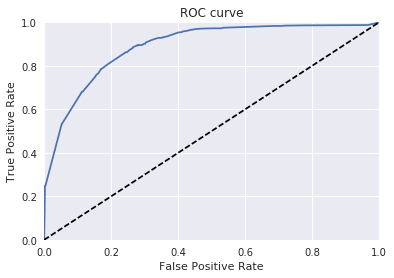

In [19]:
max_depth = 9
i = depths.index(max_depth)
dt = decision_trees[i]
auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])
print('AUC on test data: {:.3f}'.format(auc))
plotROC(y_test, dt.predict_proba(X_test)[:, 1])

Les features les plus importantes sont les suivantes:

In [20]:
variables[dt.feature_importances_ > 0.01]

Index(['age', 'education.num', 'marital.status_Married-civ-spouse',
       'hours.per.week', 'capital.change'],
      dtype='object')

On voit que dans les deux modèles, l'age, le niveau d'éducation, le nombre d'heures travaillées par semaine,
l'état civil ou encore les gains en capital sont très informatives pour permettre de prédire si une personne gagne ou non plus de 50K $ par an.

# III - Conclusions

L'utilisation de modèles non linéaires a ici relativement peu d'impact sur la métrique, par rapport à une simple régression logistique.  
Toutefois, des arbres de décisions par exemple ont l'avantage d'être plus facilement interprétables.  
Quel que soit le modèle retenu, on obtient une AUC d'environ 0,89.

### Pour aller plus loin

Afin d'améliorer les modèles prédictifs, on pourrait:
- prendre en compte les valeurs manquantes (les arbres de décisions le peuvent par exemple, mais cela n'a pas été géré ici)
- traiter les valeurs aberrantes
- préprocesser les données en faisant une ACP afin de présélectionner les features
- ajuster un peu plus finement les autres paramètres des modèles (on n'a joué seulement sur le paramètre de régularisation de la régression et sur la profondeur de l'arbre)
- utiliser d'autres types de modèles (XGBoost par exemple)
- agréger plusieurs modèles